<a href="https://colab.research.google.com/github/Potdooshami/SVO_gapmap/blob/main/svoVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📋 TODO
- [ ] from pixel unit to nano unit
- [ ] 모델 학습 완료
- [ ] 결과 그래프 개선
여기서 커밋하면?

# Rawdata
## Rawdata header
| Variable | Description | Dimensions | Notes |
|---|---|---|---|
| G | STS (Scanning Tunneling Spectroscopy) | (ix, iy, iE, iH) |  |
| Z | Topography | (ix, iy, iH) |  |
| stat | Result of G process | (ix, iy, iH, iS) | iS = {gap, peakH, subgapSate} |
| V | Bias |  |  |
| nano | nanometer |  | Unit |

In [1]:
# @title Load rawdata
# @markdown Do not touch this!!
from google.colab import drive

import h5py
import numpy as np
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/svo/fromMatlab/svo.h5'  # Replace with your actual file path

with h5py.File(file_path, 'r') as f:
    for key in f.keys():
        data = f[key][:]  # Load the dataset
        rank = data.ndim  # Get the rank
        transpose_order = tuple(range(rank - 1, -1, -1))  # Create transpose order
        globals()[key] = np.transpose(data, transpose_order)  # Transpose and assign

# Now you can access the datasets using their names (e.g., G, sp, V) with transposed indices

Mounted at /content/drive


#Function space

In [2]:
def xywh_to_xyrec(xywh):
  """Converts an xywh array to an xyrec array.

  Args:
    xywh: A 1x4 NumPy array representing [x, y, width, height].

  Returns:
    A 2x5 NumPy array representing the rectangle's corners:
    [[x1, x2, x3, x4, x1],
     [y1, y2, y3, y4, y1]]
  """
  x, y, w, h = xywh
  xyrec = np.array([[x, x + w, x + w, x, x],
                    [y, y, y + h, y + h, y]])
  return xyrec

#Visualization

## Choose window for crop

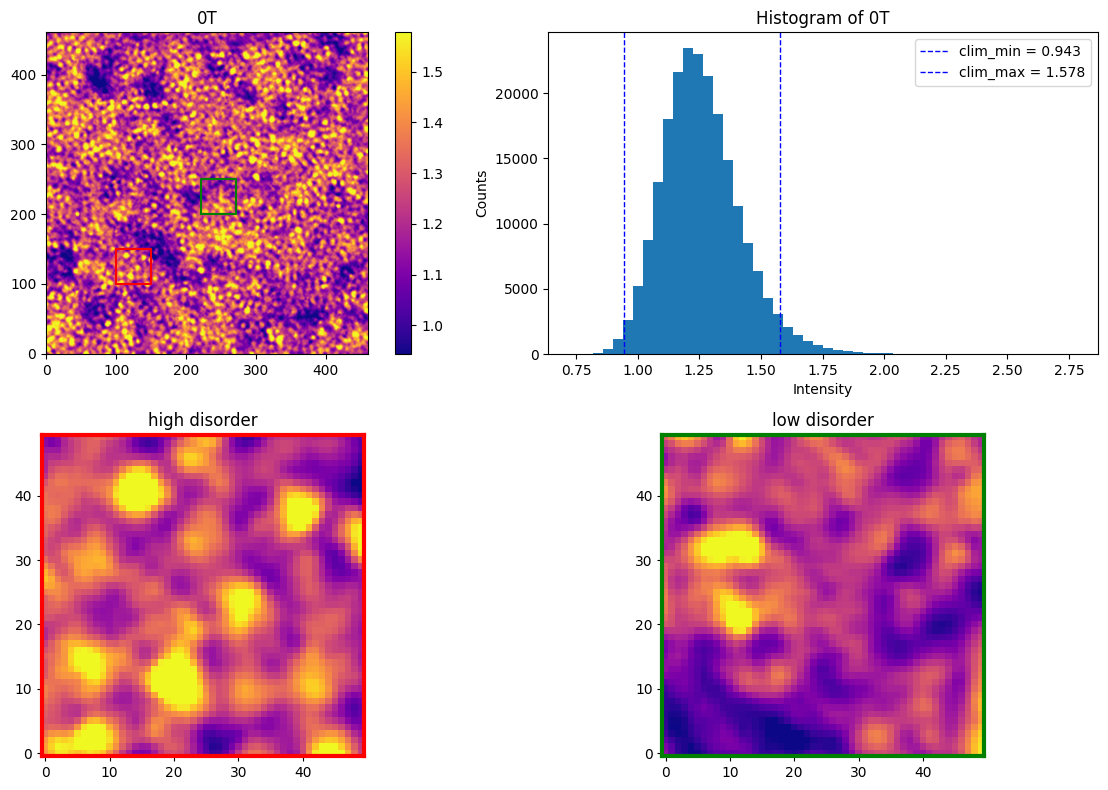

In [3]:
# @title drawing
Hfield = "0T" # @param ["0T","7T"]

# @markdown ---
floor = 2 # @param {type:"number"}
ceil  = 2 # @param {type:"number"}
# @markdown ---
xy1 = [100, 100] # @param
xy2 = [222, 200] # @param
xy =[xy1,xy2]
L = 50
clrslc = ["r","g"]
nmslc = ["high disorder","low disorder"]
iH = 0
if Hfield == "7T":
  iH = 1

# prompt: (left pannel)
# imshow Z[:,:,1] colormap gray, colorbar,
# clim +-2\sigma
# (right pannel)
# corresponding histogram
# insert clim info of left as a xline
xywh = np.array([xy1+[L, L], xy2+[L, L]])


import matplotlib.pyplot as plt

# Assuming Z is already loaded and available in the current scope

# Calculate the mean and standard deviation of Z[:,:,1]
pln_dd = stat[:,:,iH,2]
mean_Z = np.mean(pln_dd)
std_Z = np.std(pln_dd)

# Set the color limits
clim_min = mean_Z - floor * std_Z
clim_max = mean_Z + ceil * std_Z


# Create the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 8))


# Left panel: imshow of Z[:,:,1]

im = axs[0,0].imshow(pln_dd, cmap='plasma', clim=(clim_min, clim_max))
fig.colorbar(im, ax=axs[0,0])
axs[0,0].set_title(Hfield)
for isl in range(2):
  xyrec = xywh_to_xyrec(xywh[isl])
  axs[0,0].plot(xyrec[0], xyrec[1], clrslc[isl])
axs[0,0].invert_yaxis()


# Right panel: Histogram of Z[:,:,1]
axs[0,1].hist(pln_dd.flatten(), bins=50)
axs[0,1].set_title('Histogram of ' + Hfield)
axs[0,1].set_xlabel('Intensity')
axs[0,1].set_ylabel('Counts')

# Add clim info as vertical lines to the histogram
axs[0,1].axvline(clim_min, color='b', linestyle='dashed', linewidth=1, label=f'clim_min = {clim_min:.3f}')
axs[0,1].axvline(clim_max, color='b', linestyle='dashed', linewidth=1, label=f'clim_max = {clim_max:.3f}')
axs[0,1].legend()
xrng = [None,None]
yrng = [None,None]
for j in range(2):
    xrng[j] = slice(xywh[j,0],xywh[j,0]+xywh[j,2])
    yrng[j] = slice(xywh[j,1],xywh[j,1]+xywh[j,3])
    axs[1,j].imshow(pln_dd[
                      xrng[j],
                      yrng[j]],
                     cmap='plasma', clim=(clim_min, clim_max))
    axs[1,j].invert_yaxis()
    axs[1,j].set_title(nmslc[j])
    for spine in axs[1,j].spines.values():
      spine.set_edgecolor(clrslc[j])
      spine.set_linewidth(3)

plt.tight_layout()
plt.show()


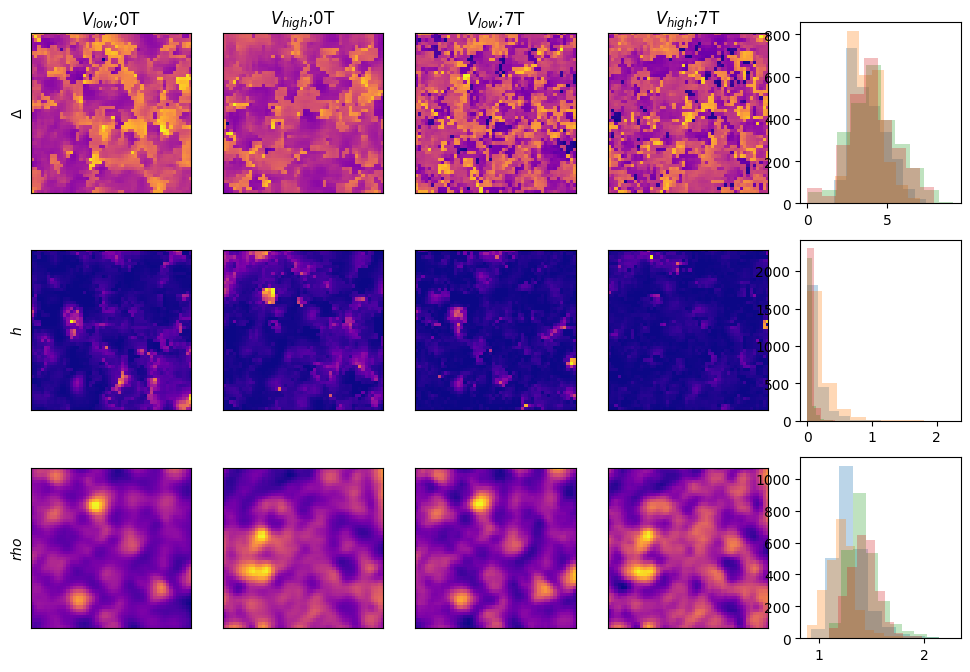

In [24]:
msb,nsb=3,5
fig,axs = plt.subplots(msb,nsb,figsize=(12, 8))
isbs,jsbs = range(msb),range(nsb)
iVs,iHs = [0,1,0,1],[0,0,1,1]
yns =  [r'$\Delta$',r'$h$',r'$rho$']
nVs = ['$V_{low}$','$V_{high}$']
nHs = ['0T','7T']
for isb,iS,yn in zip(isbs,isbs,yns):
  for jsb,iV,iH in zip(jsbs,iVs,iHs):
    nV,nH = nVs[iV],nHs[iH]
    tn = nV+';'+nH
    pln = stat[xrng[iV],yrng[iV],iH,iS]
    axs[isb,jsb].imshow(pln, cmap='plasma')
    axs[isb, jsb].set(xticks=[], yticks=[])
    if jsb ==0:
      axs[isb,jsb].set_ylabel(yn)
    if isb ==0:
      axs[isb,jsb].set_title(tn)
    axs[isb,4].hist(pln.flatten(),alpha= .3)


In [5]:
disorder = "low" # @param ["low","high"]
Hfield = "0T" # @param ["0T","7T"]
information = "subgapSate" # @param ["gap","peakH","subgapSate"]
visualization = "histogram" # @param ["image","histogram","avgDos"]

Hfield_map = {"0T": 0, "7T": 1}
iH = Hfield_map[Hfield]

disorder_map = {"low": 0, "high": 1}
iV = disorder_map[disorder]

information_map = {"gap": 0, "peakH": 1, "subgapSate": 2}
iS = information_map[information]

visualization_map = {"image": 0, "histogram": 1, "avgDos": 2}
iVIZ = visualization_map[visualization]

pln = stat[xrng[iV],yrng[iV],iH,iS]

'''
if iVIZ == 0:
  plt.imshow(pln, cmap='plasma')
  plt.show()
elif iVIZ == 1:
  plt.hist(pln.flatten(), bins=50)
  plt.show()
elif iVIZ == 2:
  plt.plot(np.mean(pln, axis=0))
  plt.show()
'''
plt.subplots(1,2, figsize=(12, 8))
plt.subplot(1,2,1)
plt.imshow(pln, cmap='plasma')
plt.subplot(1,2,2)
plt.hist(pln.flatten(), bins=50

SyntaxError: incomplete input (<ipython-input-5-801fad9fdac4>, line 35)

In [ ]:
disorder1 = "low" # @param ["low","high"]
Hfield1 = "0T" # @param ["0T","7T"]
information1 = "subgapSate" # @param ["gap","peakH","subgapSate"]
# @markdown ---
disorder2 = "high" # @param ["low","high"]
Hfield2 = "0T" # @param ["0T","7T"]
information2 = "subgapSate" # @param ["gap","peakH","subgapSate"]
disorders = [disorder1, disorder2]
Hfields = [Hfield1, Hfield2]
informations = [information1, information2]
pln = stat[xrng[iV],yrng[iV],iH,iS]
xysz = pln.shape
plns = np.zeros((
    xysz[0],xysz[1],2
    ))
for ind in range(2):
  iH = Hfield_map[Hfields[ind]]
  iV = disorder_map[disorders[ind]]
  iS = information_map[informations[ind]]
  pln = stat[xrng[iV],yrng[iV],iH,iS]
  plns[:,:,ind] = pln

# @markdown ---

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].imshow(plns[:,:,0], cmap='plasma')
axs[0,1].imshow(plns[:,:,1], cmap='plasma')